In [1]:
"""
Notated in half-steps
"""
d_partials = [0, 12, 7, 5, 3, 2]
partials = [10, 22, 29, 34, 37, 39]

"""
It's all flats because I'm a brassist and I don't hate myself
"""
notes = {10: 'Bb', 11: 'B', 0: 'C', 1: 'Db', 2: 'D', 3: 'Eb', 4: 'E', 5: 'F', 6: 'Gb', 7: 'G', 8: 'Ab', 9: 'A'}

def note_name(note_num):
    """
    Return the note in scientific note notation (note name and octave number)
    """
    return notes[note_num % 12] + str(note_num // 12 + 1)

assert(note_name(10) == 'Bb1')
assert(note_name(22) == 'Bb2')
assert(note_name(23) == 'B2')

In [2]:
def note_at(partial, position, trigger=False):
    """
    On trombone, the note played is the base note of the partial reduced by some number
    of half steps proportional to how far out the slide is.  When the slide is all the
    way in, this is "first position" (it is 1-indexed)
    """
    return partials[partial] - (position - 1) - (5 if trigger else 0)

assert(note_name(note_at(0, 1)) == 'Bb1')
assert(note_name(note_at(1, 3)) == 'Ab2')
assert(note_name(note_at(2, 1, True)) == 'C3')

In [3]:
"""
Now we need to build the reverse map of this note_at function
"""

from collections import defaultdict, namedtuple

positions = defaultdict(lambda: [])
Position = namedtuple('Position', ['partial', 'position', 'trigger'])

for partial in range(len(partials)):
    for position in range(1, 7):
        for trigger in [True, False]:
            positions[note_name(note_at(partial, position, trigger))].append(
                Position(partial, position, trigger))

positions = {partial: sorted(choices) for partial, choices in positions.items()}
            
for k, v in positions.items():
    print(k)
    for k in v:
        print('\t' + str(k))

Ab1
	Position(partial=0, position=3, trigger=False)
E1
	Position(partial=0, position=2, trigger=True)
Ab2
	Position(partial=1, position=3, trigger=False)
	Position(partial=2, position=5, trigger=True)
D2
	Position(partial=1, position=4, trigger=True)
D4
	Position(partial=5, position=2, trigger=False)
Eb1
	Position(partial=0, position=3, trigger=True)
Bb1
	Position(partial=0, position=1, trigger=False)
C2
	Position(partial=1, position=6, trigger=True)
B2
	Position(partial=2, position=2, trigger=True)
Gb1
	Position(partial=0, position=5, trigger=False)
Bb2
	Position(partial=1, position=1, trigger=False)
	Position(partial=2, position=3, trigger=True)
C4
	Position(partial=4, position=2, trigger=False)
	Position(partial=5, position=4, trigger=False)
C3
	Position(partial=2, position=1, trigger=True)
	Position(partial=2, position=6, trigger=False)
	Position(partial=3, position=6, trigger=True)
A3
	Position(partial=3, position=2, trigger=False)
	Position(partial=4, position=5, trigger=False)
	

In [4]:
test_sequence = ['C3', 'D3', 'F3', 'G3']

def gen_sequence_stupid(notes):
    """
    Use a stupid algorithm to map a sequence of notes into a sequence of positions
    """
    return [positions[note][0] for note in notes]

assert(gen_sequence_stupid(test_sequence) ==
       [Position(2, 1, True), Position(2, 4, False), Position(2, 1, False), Position(3, 4, False)])

def position_distance(a, b):
    """
    Determine the cost to move from position |a| to position |b|
    """
    return abs(a.position - b.position) + (0.5 if a.trigger != b.trigger else 0.0)

def score_sequence(seq):
    score = 0
    for i in range(len(seq) - 1):
        l, r = seq[i], seq[i + 1]
        score += position_distance(l, r)
    return score

assert(score_sequence(gen_sequence_stupid(test_sequence)) == 9.5)

In [5]:
def gen_sequence_greedy(notes):
    """
    Use a next-closest-position greedy algorithm
    """
    ret = [positions[notes[0]][0]]
    last = positions[notes[0]][0]
    for note in notes[1:]:
        minimizer = positions[note][0]
        minimum = position_distance(minimizer, last)
        for pos in positions[note]:
            if position_distance(pos, last) < minimum:
                minimum = position_distance(pos, last)
                minimizer = pos
        ret.append(minimizer)
        last = minimizer
    return ret

assert(gen_sequence_greedy(test_sequence) ==
       [Position(2, 1, True), Position(3, 4, True), Position(4, 4, True), Position(5, 4, True)])

In [15]:
"""
Brief interlude into graph land
"""
class Graph(object):
    '''
    This is an immutable graph.  Attempts to modify this graph will result in
    returning a new graph
    '''
    def __init__(self, lines=None):
        self.lines = lines or {}
    
    def get_neighbors(self, node):
        '''Get all the neighbors of the given node and the cost to get there'''
        ret = {}
        for pair, cost in self.lines.items():
            if pair[0] == node:
                ret[pair[1]] = cost
            elif pair[1] == node:
                ret[pair[0]] = cost
        return ret
    
    def add_line(self, a, b, cost):
        '''Add a connection to the graph and return the new graph'''
        new_lines = dict(self.lines)
        new_lines[tuple(sorted([a, b]))] = cost
        return Graph(new_lines)
    
    def get_nodes(self):
        ret = set()
        for nodea, nodeb in self.lines.keys():
            ret.add(nodea)
            ret.add(nodeb)
        return ret
    
    def get_neighbors(self, node):
        neighbors = set()
        for nodea, nodeb in self.lines.keys():
            if nodea == node:
                neighbors.add(nodeb)
        return neighbors
    
    def get_edges(self):
        return dict(self.lines)
    
    def get_cost(self, a, b):
        return self.lines[tuple(sorted([a, b]))]
    
    def __str__(self):
        ret = ""
        for path, cost in self.lines.items():
            ret += ("From %s to %s: %d\n" % (path[0], path[1], cost))
        return ret

In [7]:
"""
Turn this trombone pathfinding problem into a graph and solve using something resembling bellman ford
"""

def create_sequence_graph(notes):
    '''Map this sequence of notes into a one-directional graph'''
    graph = Graph()
    source_nodes = [(0, "start")]
    dest_nodes = []
    level = 1
    for note in notes:
        dest_nodes = [(level, pos) for pos in positions[note]]
        for src in source_nodes:
            for dst in dest_nodes:
                if src == (0, "start"):
                    cost = 0
                else:
                    cost = position_distance(src[1], dst[1])
                graph = graph.add_line(src, dst, cost)
        level += 1
        source_nodes = dest_nodes
    
    for src in source_nodes:
        graph = graph.add_line(src, (level, "end"), 0)
    
    return graph

def solve_bellman_ford(source, dest, graph):
    """I strongly disagree with my textbook on this one"""
    best = {source: 0}
    predecessor = {}
    to_visit = set([(0, "start")])
    while len(to_visit) > 0:
        this = to_visit.pop()
        for neighbor in graph.get_neighbors(this):
            this_cost = best[this] + graph.get_cost(this, neighbor)
            if neighbor not in best or this_cost < best[neighbor]:
                predecessor[neighbor] = this
                best[neighbor] = this_cost
                to_visit.add(neighbor)
    
    ret = []
    i = dest
    while i != source and len(ret) < 10:
        ret = [i] + ret
        i = predecessor[i]
    ret = [i] + ret
    return ret

def gen_sequence_dijkstra(notes):
    """
    use Dijkstra's pathfinding algorithm to find an optimal path through the position-graph
    """
    graph = create_sequence_graph(notes)
    source = (0, "start")
    dest = (len(notes) + 1, "end")
    path = solve_bellman_ford(source, dest, graph)[1:-1]
    print(path)
    
gen_sequence_dijkstra(test_sequence)

[(1, Position(partial=3, position=6, trigger=True)), (2, Position(partial=3, position=4, trigger=True)), (3, Position(partial=4, position=4, trigger=True)), (4, Position(partial=5, position=4, trigger=True))]


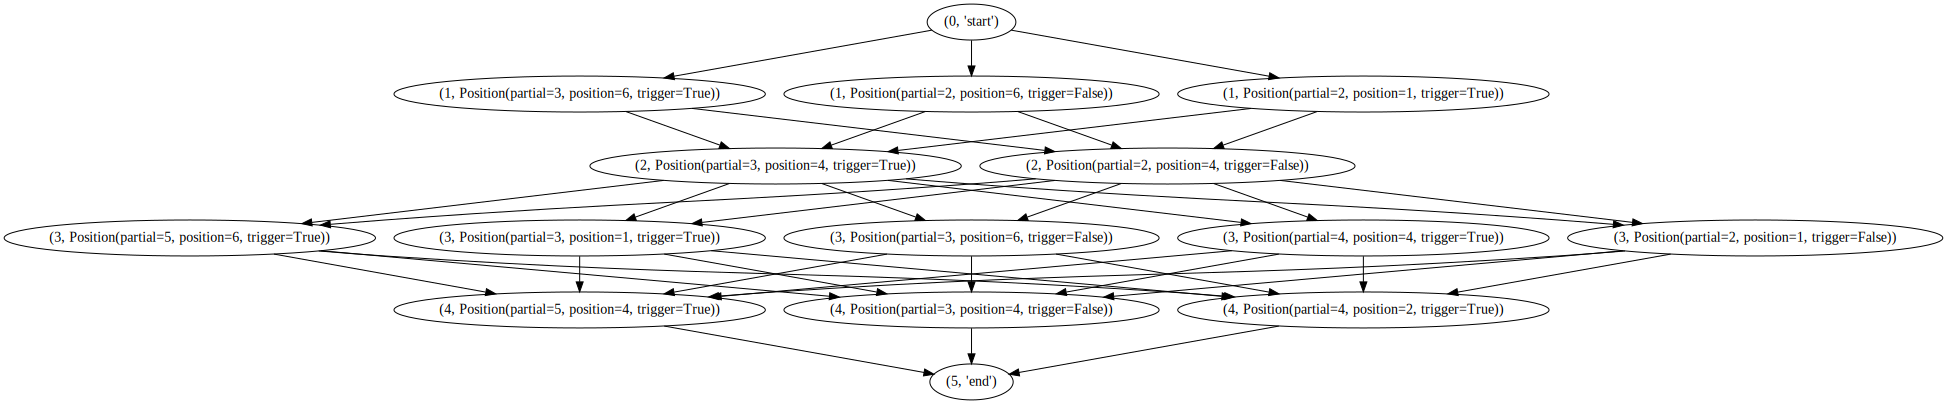

In [22]:
"""
Let's draw these graphs to help explain what just happened there
"""
import graphviz as gv

def convert_mygraph_to_dvgraph(mygraph):
    g = gv.Digraph(format='svg')
    
    nodes = mygraph.get_nodes()
    for node in nodes:
        g.node(str(node))
    
    edges = mygraph.get_edges()
    for edges, cost in edges.items():
        a, b = edges
        g.edge(str(a), str(b))
    
    return g

convert_mygraph_to_dvgraph(create_sequence_graph(test_sequence))

"""
Per the diagram below, the sequence of notes and ways to play each note were transformed into a digraph.  Each
layer represents all the possible ways to play the nth note of the sequence.  All nodes in layer n connect to
all nodes in layer n+1.  At the beginning and end are cap nodes that serve as source and destination for
bellman ford.  The edge cost is the distance between the two connected positions.  
"""